In [ ]:
import os, math, hashlib, random
from dataclasses import dataclass
from typing import List
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

payload_str = "EU01A1BG5T20251027ABCD"
print("Payload string:", payload_str)

# Convert payload to a 32-bit checksum
def payload_to_32bits(s: str) -> List[int]:
    """
    Map an arbitrary string to a deterministic 32-bit checksum.
    Here we use SHA-256 and take the first 32 bits.
    """
    h = hashlib.sha256(s.encode("ascii")).digest()
    v = int.from_bytes(h[:4], "big")  # 32 bits
    bits = [(v >> (31 - i)) & 1 for i in range(32)]
    return bits

bits32 = payload_to_32bits(payload_str)
print("Checksum bits (32):", "".join(str(b) for b in bits32))

# Keep the integer value as well (easy to compare)
def bits_to_int(bits: List[int]) -> int:
    v = 0
    for b in bits:
        v = (v << 1) | b
    return v

checksum_ref_int = bits_to_int(bits32)
print("Checksum int:", checksum_ref_int)

# Hamming(7,4) ECC + repetition
def hamming74_encode_block(n4: List[int]) -> List[int]:
    assert len(n4) == 4
    d1, d2, d3, d4 = n4
    p1 = d1 ^ d2 ^ d4
    p2 = d1 ^ d3 ^ d4
    p3 = d2 ^ d3 ^ d4
    return [p1, p2, d1, p3, d2, d3, d4]

def hamming74_decode_block(c7: List[int]):
    assert len(c7) == 7
    p1, p2, d1, p3, d2, d3, d4 = c7
    s1 = p1 ^ d1 ^ d2 ^ d4
    s2 = p2 ^ d1 ^ d3 ^ d4
    s3 = p3 ^ d2 ^ d3 ^ d4
    syndrome = (s3 << 2) | (s2 << 1) | s1
    corrected = c7[:]
    if syndrome != 0 and 1 <= syndrome <= 7:
        corrected[syndrome - 1] ^= 1
    _, _, d1, _, d2, d3, d4 = corrected
    return [d1, d2, d3, d4], syndrome

def hamming74_encode(bits: List[int]):
    pad = (4 - (len(bits) % 4)) % 4
    bits_padded = bits + [0] * pad
    out = []
    for i in range(0, len(bits_padded), 4):
        out.extend(hamming74_encode_block(bits_padded[i:i+4]))
    return out, pad

def hamming74_decode(bits: List[int], pad: int):
    assert len(bits) % 7 == 0
    out = []
    total_syndrome = 0
    for i in range(0, len(bits), 7):
        data, syn = hamming74_decode_block(bits[i:i+7])
        out.extend(data)
        if syn != 0:
            total_syndrome += 1
    if pad:
        out = out[:-pad]
    return out, total_syndrome

def repeat_bits(bits: List[int], r: int) -> List[int]:
    return [b for bit in bits for b in [bit] * r]

def majority_vote(groups: List[List[int]]) -> List[int]:
    return [1 if sum(g) * 2 >= len(g) else 0 for g in groups]

# Encode checksum bits with Hamming(7,4)
ecc_bits, pad = hamming74_encode(bits32)
print("ECC length:", len(ecc_bits), "pad:", pad)


Payload string: EU01A1BG5T20251027ABCD
Checksum bits (32): 11011000000100111111100011000001
Checksum int: 3625187521
ECC length: 56 pad: 0


In [2]:
BASE_H, BASE_W = 720, 960  # base size we always resize to

def load_img(path: str) -> np.ndarray:
    return np.array(Image.open(path).convert("RGB"))

def save_img(arr: np.ndarray, path: str, quality=None):
    img = Image.fromarray(arr.astype(np.uint8))
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
    if quality is None:
        img.save(path)
    else:
        img.save(path, quality=quality, subsampling=2, optimize=True)

def to_base_size(img: np.ndarray) -> np.ndarray:
    im = Image.fromarray(img.astype(np.uint8))
    im2 = im.resize((BASE_W, BASE_H), Image.Resampling.BICUBIC)
    return np.array(im2, dtype=np.uint8)

def rgb_to_luma(img: np.ndarray) -> np.ndarray:
    r, g, b = img[...,0], img[...,1], img[...,2]
    y = 0.299*r + 0.587*g + 0.114*b
    return y.astype(np.float32)

def luma_to_rgb(y: np.ndarray, orig: np.ndarray) -> np.ndarray:
    y = np.clip(y, 0, 255).astype(np.float32)
    old_y = rgb_to_luma(orig).astype(np.float32) + 1e-6
    scale = y / old_y                      # (H,W)
    scale3 = np.stack([scale, scale, scale], axis=-1)  # (H,W,3)
    out = orig.astype(np.float32) * scale3
    return np.clip(out, 0, 255).astype(np.uint8)


In [3]:
@dataclass
class InvisECCConfig:
    alpha: float = 2.5     # embedding strength (tune)
    repeat: int = 5        # repetition per ECC bit
    seed: int = 20251120   # master seed

def gen_tile_noise(h: int, w: int, seed: int) -> np.ndarray:
    """
    Generate a zero-mean, unit-std pseudo-random +/-1 pattern.
    """
    rng = np.random.RandomState(seed)
    noise = rng.choice([-1.0, 1.0], size=(h, w)).astype(np.float32)
    noise = noise - noise.mean()
    std = noise.std() + 1e-6
    return noise / std

def embed_invisible_ecc(img: np.ndarray, ecc_bits: List[int], cfg: InvisECCConfig):
    """
    Embed ECC bits with repetition into vertical tiles using invisible PN patterns.
    """
    bits_rep = repeat_bits(ecc_bits, cfg.repeat)
    n_embed_bits = len(bits_rep)

    img_b = to_base_size(img)
    y = rgb_to_luma(img_b)
    H, W = y.shape

    tile_w = max(1, W // n_embed_bits)
    y0 = H // 4
    y1 = 3 * H // 4
    band_h = y1 - y0

    y_mod = y.copy()

    for i, bit in enumerate(bits_rep):
        x0 = i * tile_w
        if x0 >= W:
            break
        x1 = min(W, x0 + tile_w)
        w_eff = x1 - x0
        if w_eff <= 0:
            break

        noise = gen_tile_noise(band_h, w_eff, seed=cfg.seed + i)
        m = 1.0 if bit == 1 else -1.0
        y_mod[y0:y1, x0:x1] += cfg.alpha * m * noise

    wm_img = luma_to_rgb(y_mod, img_b)
    return wm_img

def detect_invisible_ecc(img: np.ndarray, cfg: InvisECCConfig, ecc_len: int):
    """
    Detect ECC bits from image:
      - recover repeated bits via correlation sign
      - majority-vote per ECC bit
    """
    img_b = to_base_size(img)
    y = rgb_to_luma(img_b)
    H, W = y.shape

    n_embed_bits = ecc_len * cfg.repeat
    tile_w = max(1, W // n_embed_bits)
    y0 = H // 4
    y1 = 3 * H // 4
    band_h = y1 - y0

    bits_obs = []

    for i in range(n_embed_bits):
        x0 = i * tile_w
        if x0 >= W:
            break
        x1 = min(W, x0 + tile_w)
        w_eff = x1 - x0
        if w_eff <= 0:
            break

        tile = y[y0:y1, x0:x1]
        noise = gen_tile_noise(band_h, w_eff, seed=cfg.seed + i)

        num = float((tile * noise).sum())
        den = float(np.linalg.norm(tile) * np.linalg.norm(noise) + 1e-6)
        corr = num / den
        bits_obs.append(1 if corr > 0 else 0)

    # pad/truncate to exact length
    bits_obs = bits_obs[:n_embed_bits]
    if len(bits_obs) < n_embed_bits:
        bits_obs += [0] * (n_embed_bits - len(bits_obs))

    # group per ECC bit (repetition)
    groups = [
        bits_obs[i*cfg.repeat:(i+1)*cfg.repeat]
        for i in range(ecc_len)
    ]
    groups = [g for g in groups if len(g) == cfg.repeat]
    voted = majority_vote(groups)  # length <= ecc_len

    return voted


Saved cover       : ./out_ecc\cover.png
Saved watermarked : ./out_ecc\watermarked_ecc.png


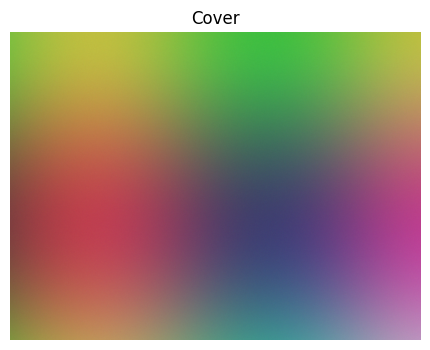

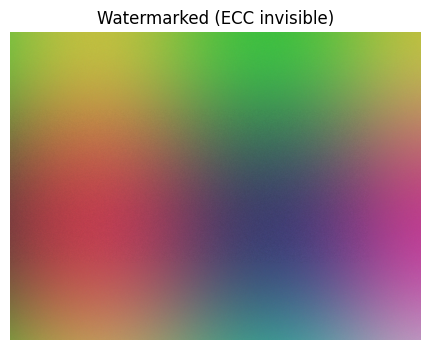

Hamming syndrome blocks corrected: 0
Decoded checksum int: 3625187521
Matches original checksum exactly? True
Hamming distance (32 bits): 0


In [ ]:
cfg_ecc = InvisECCConfig(alpha=2.5, repeat=5, seed=20251120)

# Synthetic cover image
def synth_image(h=BASE_H, w=BASE_W):
    yy, xx = np.meshgrid(np.linspace(0,1,h), np.linspace(0,1,w), indexing="ij")
    r = (np.sin(2*np.pi*(xx*1.2)) * 0.25 + 0.5) * 255
    g = (np.cos(2*np.pi*(yy*0.8)) * 0.25 + 0.5) * 255
    b = ((xx*yy) * 0.5 + 0.25) * 255
    img = np.stack([r, g, b], axis=-1)
    noise = np.random.normal(0, 2.0, img.shape)
    return np.clip(img + noise, 0, 255).astype(np.uint8)

cover = synth_image()
wm_img = embed_invisible_ecc(cover, ecc_bits, cfg_ecc)

OUTDIR = "./out_ecc"
os.makedirs(OUTDIR, exist_ok=True)
cover_path = os.path.join(OUTDIR, "cover.png")
wm_path    = os.path.join(OUTDIR, "watermarked_ecc.png")
save_img(cover, cover_path)
save_img(wm_img, wm_path)

print("Saved cover       :", cover_path)
print("Saved watermarked :", wm_path)

plt.figure(figsize=(6,4)); plt.imshow(cover.astype(np.uint8));  plt.axis("off"); plt.title("Cover"); plt.show()
plt.figure(figsize=(6,4)); plt.imshow(wm_img.astype(np.uint8)); plt.axis("off"); plt.title("Watermarked (ECC invisible)"); plt.show()

# Verify on the saved file (no screenshot yet)
wm_loaded = load_img(wm_path)
ecc_rec = detect_invisible_ecc(wm_loaded, cfg_ecc, ecc_len=len(ecc_bits))

dec_bits32, corrected_blocks = hamming74_decode(ecc_rec, pad)
print("Hamming syndrome blocks corrected:", corrected_blocks)

# Trim decoded bits to 32
dec_bits32 = dec_bits32[:32]
checksum_dec_int = bits_to_int(dec_bits32)

print("Decoded checksum int:", checksum_dec_int)
print("Matches original checksum exactly?", checksum_dec_int == checksum_ref_int)
print("Hamming distance (32 bits):", sum(a!=b for a,b in zip(bits32, dec_bits32)))


In [ ]:
# Path to your real screenshot:
screenshot_path = r"D:\GIT\Thesis\experiment1\out_ecc\screenshot copy.png"

shot = load_img(screenshot_path)

ecc_rec_shot = detect_invisible_ecc(shot, cfg_ecc, ecc_len=len(ecc_bits))
dec_bits32_shot, corrected_blocks_shot = hamming74_decode(ecc_rec_shot, pad)
dec_bits32_shot = dec_bits32_shot[:32]
checksum_dec_shot_int = bits_to_int(dec_bits32_shot)

hd = sum(a!=b for a,b in zip(bits32, dec_bits32_shot))

print("Decoded checksum from screenshot:", checksum_dec_shot_int)
print("Matches original checksum exactly?", checksum_dec_shot_int == checksum_ref_int)
print("Hamming distance (32 bits):", hd)
print("Corrected blocks:", corrected_blocks_shot)


Decoded checksum from screenshot: 3625187521
Matches original checksum exactly? True
Hamming distance (32 bits): 0
Corrected blocks: 0
